In [25]:
import torch
from torch import nn
import matplotlib.pyplot as plt

from sklearn.datasets import make_circles
from sklearn.model_selection import train_test_split
from helper_functions import plot_predictions, plot_decision_boundary

In [3]:
n_samples = 1000

X, y = make_circles(n_samples, noise = 0.03, random_state=42)

In [4]:
X.shape, y.shape

((1000, 2), (1000,))

In [5]:
X[:5], y[:5]

(array([[ 0.75424625,  0.23148074],
        [-0.75615888,  0.15325888],
        [-0.81539193,  0.17328203],
        [-0.39373073,  0.69288277],
        [ 0.44220765, -0.89672343]]),
 array([1, 1, 1, 1, 0]))

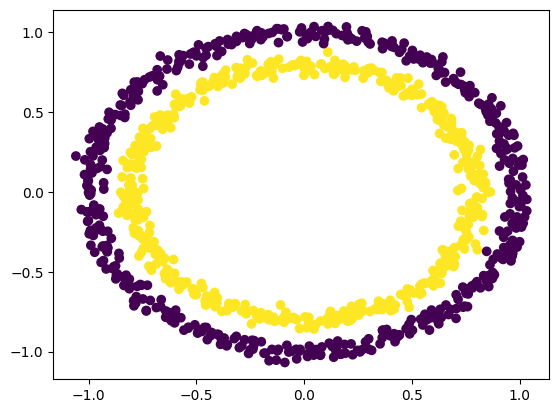

In [6]:
plt.scatter(x = X[:, 0], y= X[:, 1], c = y)

In [7]:
X = torch.from_numpy(X).type(torch.float)
y = torch.from_numpy(y).type(torch.float)

X[:5], y[:5]

(tensor([[ 0.7542,  0.2315],
         [-0.7562,  0.1533],
         [-0.8154,  0.1733],
         [-0.3937,  0.6929],
         [ 0.4422, -0.8967]]),
 tensor([1., 1., 1., 1., 0.]))

In [8]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 42)

X_train.shape, X_test.shape, y_train.shape, y_test.shape

(torch.Size([800, 2]),
 torch.Size([200, 2]),
 torch.Size([800]),
 torch.Size([200]))

> Build a Model

In [9]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
device

'cuda'

In [10]:
class CircleModelVo(nn.Module):
  def __init__(self):
    super().__init__()

    self.layer_1 = nn.Linear(in_features = 2, out_features = 5)
    self.layer_2 = nn.Linear(in_features = 5, out_features = 1)

  def forward(self, X:torch.tensor):
    return self.layer_2(self.layer_1(X))

In [11]:
model_0 = CircleModelVo().to(device)
model_0

CircleModelVo(
  (layer_1): Linear(in_features=2, out_features=5, bias=True)
  (layer_2): Linear(in_features=5, out_features=1, bias=True)
)

In [12]:
model_0.state_dict()

OrderedDict([('layer_1.weight',
              tensor([[-0.1050, -0.1920],
                      [ 0.3987,  0.5987],
                      [ 0.2069,  0.3482],
                      [-0.3903,  0.2981],
                      [ 0.5510, -0.2727]], device='cuda:0')),
             ('layer_1.bias',
              tensor([-0.2745, -0.0109,  0.2582,  0.2014, -0.4251], device='cuda:0')),
             ('layer_2.weight',
              tensor([[-0.3906, -0.1004,  0.2742,  0.3634,  0.2899]], device='cuda:0')),
             ('layer_2.bias', tensor([-0.3265], device='cuda:0'))])

In [13]:
untrained_preds = model_0(X_test.to(device))

print(f'Length of predictions: {untrained_preds.shape}')
print(f'Length of test target samples: {y_test.shape}')


Length of predictions: torch.Size([200, 1])
Length of test target samples: torch.Size([200])


In [14]:
loss_fn = nn.BCEWithLogitsLoss()

optimizer = torch.optim.SGD(params = model_0.parameters(), lr = 1e-1)

In [15]:
def accuracy_fn(y_true, y_pred):
  correct = torch.eq(y_true, y_pred).sum().item()
  acc = (correct / len(y_pred)) * 100
  return acc

In [16]:
y_logits = model_0(X_test.to(device))[:5]
y_logits

tensor([[-0.1304],
        [-0.0622],
        [-0.2945],
        [-0.0840],
        [-0.2708]], device='cuda:0', grad_fn=<SliceBackward0>)

In [17]:
y_pred_probs = torch.sigmoid(y_logits)
y_pred_probs

tensor([[0.4674],
        [0.4845],
        [0.4269],
        [0.4790],
        [0.4327]], device='cuda:0', grad_fn=<SigmoidBackward0>)

In [20]:
y_preds = torch.round(y_pred_probs)
y_pred_labels = torch.round(torch.sigmoid(model_0(X_test.to(device))[:5]))
print(torch.eq(y_preds.squeeze(), y_pred_labels.squeeze()))
y_preds.squeeze()

tensor([True, True, True, True, True], device='cuda:0')


tensor([0., 0., 0., 0., 0.], device='cuda:0', grad_fn=<SqueezeBackward0>)

In [21]:
y_test[:5]

tensor([1., 0., 1., 0., 1.])

> Building a Training Loop

In [22]:
torch.manual_seed(42)

epochs = 100

X_train, y_train = X_train.to(device), y_train.to(device)
X_test, y_test = X_test.to(device), y_test.to(device)

for epoch in range(epochs):

  model_0.train()

  y_logits = model_0(X_train).squeeze()
  y_pred = torch.round(torch.sigmoid(y_logits))

  loss = loss_fn(y_pred, y_train)
  acc = accuracy_fn(y_train, y_pred)

  optimizer.zero_grad()
  loss.backward()
  optimizer.step()

  model_0.eval()

  with torch.inference_mode():

    test_logits = model_0(X_test).squeeze()
    test_pred = torch.round(torch.sigmoid(test_logits))
    test_loss = loss_fn(test_pred, y_test)
    test_acc = accuracy_fn(y_test, test_pred)

  if epoch % 10 == 0:
    print(f'Epoch: {epoch} | Loss: {loss:.2f} | Accuracy: {acc:.2f} | Test Loss: {test_loss:.2f} | Test Accuracy: {test_acc:.2f}')

Epoch: 0 | Loss: 0.69 | Accuracy: 50.00 | Test Loss: 0.69 | Test Accuracy: 50.00
Epoch: 10 | Loss: 0.69 | Accuracy: 50.00 | Test Loss: 0.69 | Test Accuracy: 50.00
Epoch: 20 | Loss: 0.69 | Accuracy: 50.00 | Test Loss: 0.69 | Test Accuracy: 50.00
Epoch: 30 | Loss: 0.69 | Accuracy: 50.00 | Test Loss: 0.69 | Test Accuracy: 50.00
Epoch: 40 | Loss: 0.69 | Accuracy: 50.00 | Test Loss: 0.69 | Test Accuracy: 50.00
Epoch: 50 | Loss: 0.69 | Accuracy: 50.00 | Test Loss: 0.69 | Test Accuracy: 50.00
Epoch: 60 | Loss: 0.69 | Accuracy: 50.00 | Test Loss: 0.69 | Test Accuracy: 50.00
Epoch: 70 | Loss: 0.69 | Accuracy: 50.00 | Test Loss: 0.69 | Test Accuracy: 50.00
Epoch: 80 | Loss: 0.69 | Accuracy: 50.00 | Test Loss: 0.69 | Test Accuracy: 50.00
Epoch: 90 | Loss: 0.69 | Accuracy: 50.00 | Test Loss: 0.69 | Test Accuracy: 50.00


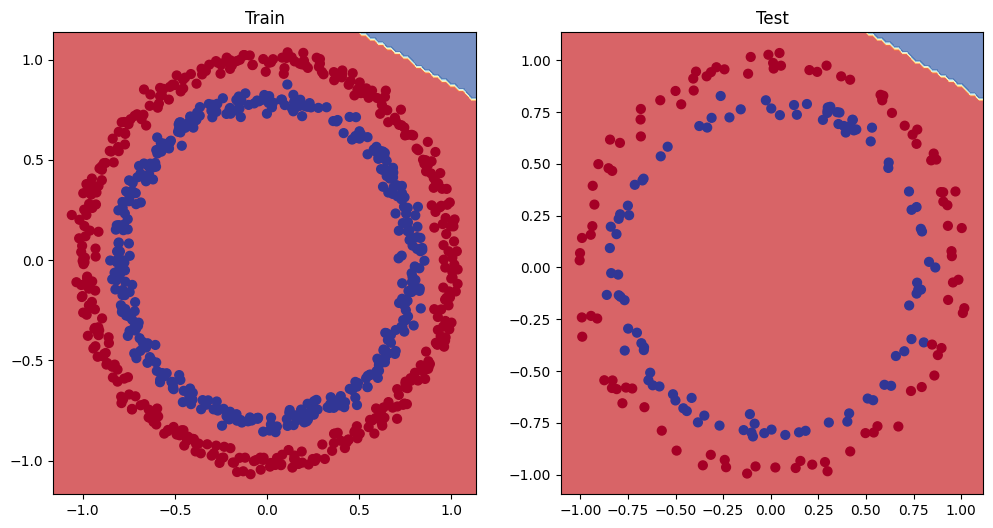

In [26]:
plt.figure(figsize = (12,6))
plt.subplot(1,2,1)
plt.title('Train')
plot_decision_boundary(model_0, X_train, y_train)
plt.subplot(1,2,2)
plt.title('Test')
plot_decision_boundary(model_0, X_test, y_test)

> Bulding a model with Non-Linearity

In [ ]:
class CircleModelV1(nn.Moduele):
  def __init__(self):
    super().__init__()